# Energy Demand Clustering

In this project, we will
* Explore a dataset and carry out clustering using k-means algorithm
* Identify the optimum number of clusters for a given dataset

## Problem Description

In this project, we will study the electricity demand from clients in Portugal, during 2013 and 2014. We will use clustering techniques to understand the typical usage behaviour. <br>
The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

Both these datasets are publicly available, and can be used to carry out experiments. Their source is below:

 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


### Dataset Description
Data set has no missing values.
Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.
All time labels report to Portuguese hour. However all days present 96 measures (24*4). Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points. Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.

## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed. The data file has been provided with this assignment. It is also available at the links provided above.

### Load Data

In [17]:
import urllib.request
import zipfile

In [16]:
# download the zip file to working directory
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip'
filename,_ = urllib.request.urlretrieve(url,"LD2011_2014.txt.zip") 
# unzip the downloaded file
with zipfile.ZipFile(filename) as item: # treat the file as a zip
    item.extractall()

In [22]:
pathToFile = r""
fileName = 'LD2011_2014.txt'

# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput
with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

### **Read in data**

In [23]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)
print(data.shape)

(140256, 370)


In [24]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

### Quick data inspection

In [ ]:
data.head(2)

MT_001  MT_002  MT_003  ...  MT_368  MT_369  MT_370
2011-01-01 00:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0
2011-01-01 00:30:00     0.0     0.0     0.0  ...     0.0     0.0     0.0

[2 rows x 370 columns]

In [ ]:
data.tail(2)

MT_001     MT_002  ...      MT_369       MT_370
2014-12-31 23:45:00  1.269036  21.337127  ...  646.627566  6540.540541
2015-01-01 00:00:00  2.538071  19.914651  ...  673.020528  7135.135135

[2 rows x 370 columns]

In [ ]:
data.shape

(140256, 370)

In [9]:
range(2,10)[0]

2

**As it can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.**

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [361]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [ ]:
data.describe()

MT_001         MT_002  ...         MT_369         MT_370
count  140256.000000  140256.000000  ...  140256.000000  140256.000000
mean        3.970785      20.768480  ...     625.251734    8722.355145
std         5.983965      13.272415  ...     380.656042    9195.155777
min         0.000000       0.000000  ...       0.000000       0.000000
25%         0.000000       2.844950  ...      83.944282       0.000000
50%         1.269036      24.893314  ...     758.064516       0.000000
75%         2.538071      29.871977  ...     875.366569   17783.783784
max        48.223350     115.220484  ...    1549.120235   30918.918919

[8 rows x 370 columns]

### Plot the first 2 days of 2012 for the first 2 clients

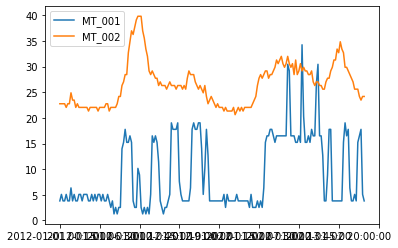

In [ ]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()


**We note that the main difference between the curves is the level (also seen on the means in df.describe()).  We will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day.**

### Data for the analysis

In [25]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [5]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [6]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


We focus on ***2013 and 2014*** because these are the years with low number of clients having zero demand

In [27]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


### Getting average curves per client

In [28]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [29]:
data.index

Index(['2013-01-01 00:15:00', '2013-01-01 00:30:00', '2013-01-01 00:45:00',
       '2013-01-01 01:00:00', '2013-01-01 01:15:00', '2013-01-01 01:30:00',
       '2013-01-01 01:45:00', '2013-01-01 02:00:00', '2013-01-01 02:15:00',
       '2013-01-01 02:30:00',
       ...
       '2014-12-31 21:45:00', '2014-12-31 22:00:00', '2014-12-31 22:15:00',
       '2014-12-31 22:30:00', '2014-12-31 22:45:00', '2014-12-31 23:00:00',
       '2014-12-31 23:15:00', '2014-12-31 23:30:00', '2014-12-31 23:45:00',
       '2015-01-01 00:00:00'],
      dtype='object', length=70080)

In [31]:
data['hour'] = data.index.map(lambda x: x[11:])

In [32]:
data.head(3)

MT_001     MT_002    MT_003      MT_004     MT_005  \
2013-01-01 00:15:00  2.538071  22.759602  2.606429  138.211382  63.414634   
2013-01-01 00:30:00  1.269036  22.759602  2.606429  138.211382  63.414634   
2013-01-01 00:45:00  2.538071  22.759602  2.606429  134.146341  60.975610   

                         MT_006    MT_007      MT_008     MT_009     MT_010  \
2013-01-01 00:15:00  255.952381  4.522329  239.057239  57.692308  78.494624   
2013-01-01 00:30:00  264.880952  5.652911  228.956229  57.692308  76.344086   
2013-01-01 00:45:00  250.000000  5.652911  239.057239  54.195804  76.344086   

                     ...   MT_362      MT_363       MT_364     MT_365  \
2013-01-01 00:15:00  ...  22300.0  886.075949  1000.000000  16.949153   
2013-01-01 00:30:00  ...  21000.0  864.978903   909.090909  18.252934   
2013-01-01 00:45:00  ...  18200.0  860.759494   840.909091  16.949153   

                       MT_366      MT_367     MT_368      MT_369       MT_370  \
2013-01-01 00:15:00  6.436513  616.330114  76.794658  731.671554  8086.486486   
2013-01-01 00:30:00  3.510825  564.530290  76.794658  727.272727  8086.486486   
2013-01-01 00:45:00  5.851375  590.869183  68.447412  730.205279  7848.648649   

                         hour  
2013-01-01 00:15:00  00:15:00  
2013-01-01 00:30:00  00:30:00  
2013-01-01 00:45:00  00:45:00  

[3 rows x 350 columns]

### Getting average curves per client

In [37]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

The dataframe average_curves contains the 349 typical weekday electric demands
<br>We now divide each curve by its mean, so that all curves have mean 1

In [38]:
average_curves_norm = average_curves/(average_curves.mean())
average_curves_norm.head()

MT_001    MT_002    MT_003    MT_004    MT_005    MT_006  \
hour                                                                   
00:00:00  0.964792  0.926674  0.991800  1.140106  1.186498  1.008914   
00:15:00  0.947378  0.919117  0.977796  1.099159  1.131703  0.946419   
00:30:00  0.960104  0.880744  0.976579  1.061641  1.090238  0.905552   
00:45:00  0.959434  0.877243  0.971708  1.030153  1.053960  0.868064   
01:00:00  0.956085  0.841989  0.953443  0.975761  1.024347  0.822656   

            MT_007    MT_008    MT_009    MT_010  ...    MT_361    MT_362  \
hour                                              ...                       
00:00:00  1.170686  0.946572  0.983915  0.948867  ...  0.414676  0.748555   
00:15:00  1.118666  0.909376  0.953996  0.924425  ...  0.414381  0.662602   
00:30:00  1.081459  0.881217  0.931614  0.908674  ...  0.386706  0.561815   
00:45:00  1.056382  0.855331  0.907404  0.885073  ...  0.337499  0.499651   
01:00:00  1.030838  0.830275  0.888265  0.869041  ...  0.318475  0.422753   

            MT_363    MT_364    MT_365    MT_366    MT_367    MT_368  \
hour                                                                   
00:00:00  0.561491  0.430085  0.471574  1.358632  1.215272  1.170441   
00:15:00  0.412336  0.375704  0.423108  1.365299  1.184899  1.223818   
00:30:00  0.395294  0.344682  0.386975  1.312627  1.177781  1.211343   
00:45:00  0.352628  0.295219  0.377024  1.245171  1.156699  1.189829   
01:00:00  0.342066  0.288892  0.369187  1.292298  1.149629  1.167326   

            MT_369    MT_370  
hour                          
00:00:00  0.974307  0.992967  
00:15:00  0.969266  1.000548  
00:30:00  0.947969  1.008515  
00:45:00  0.937889  1.007613  
01:00:00  0.931284  1.006770  

[5 rows x 349 columns]

### Plot the first 2 and last 2 clients

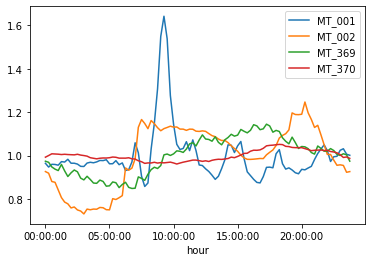

In [ ]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [39]:
X = average_curves_norm.copy()  # We call this normalized curve
X = np.array(X.T) # put it on the right format
X.shape

(349, 96)

# **Analysis**

## a. Determine what a convenient number of cluster

**Rationale:** Certain customers consume electricity more during certain period of time in a day. We could set the number fo clusters for 3, e.g., High consumption during the day, high evening consumption and high overnight consumption.

### Inital attempt with KMeans(3)

In [128]:
# set the number of clusters
n_clusters = 3
km = KMeans(n_clusters, random_state=42).fit(X)
y_pred = km.labels_
y_pred[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [129]:
# Get the inertia
km.inertia_

865.9677208804299

Let's plot the data in the same cluster

### Plot Elbow graph
We will calculate the sum of squared error for k from 1 to 10 to see if optimal k is within the range of 1 to 10

In [16]:
def plot_optimal_k(k_range, sse, ylab='Sum of Squared Errors'):
  plt.figure(figsize=(6,4))
  plt.xlabel('K', fontsize=14)
  plt.ylabel(ylab, fontsize=14)
  plt.title(ylab, fontsize=18)
  plt.plot(k_range, sse, marker='x')

In [121]:
# Plot the elbow graph
k_range = range(1,11)
km = [KMeans(n_clusters=k, random_state=42).fit(X) for k in k_range]
sse = [model.inertia_ for model in km]
sse

[1707.2294200296337,
 1175.527275423089,
 865.9677208804299,
 657.6442657822122,
 553.8293402213444,
 476.53767360414736,
 426.47128190385325,
 391.5164433291331,
 368.4385132512763,
 347.0544778908123]

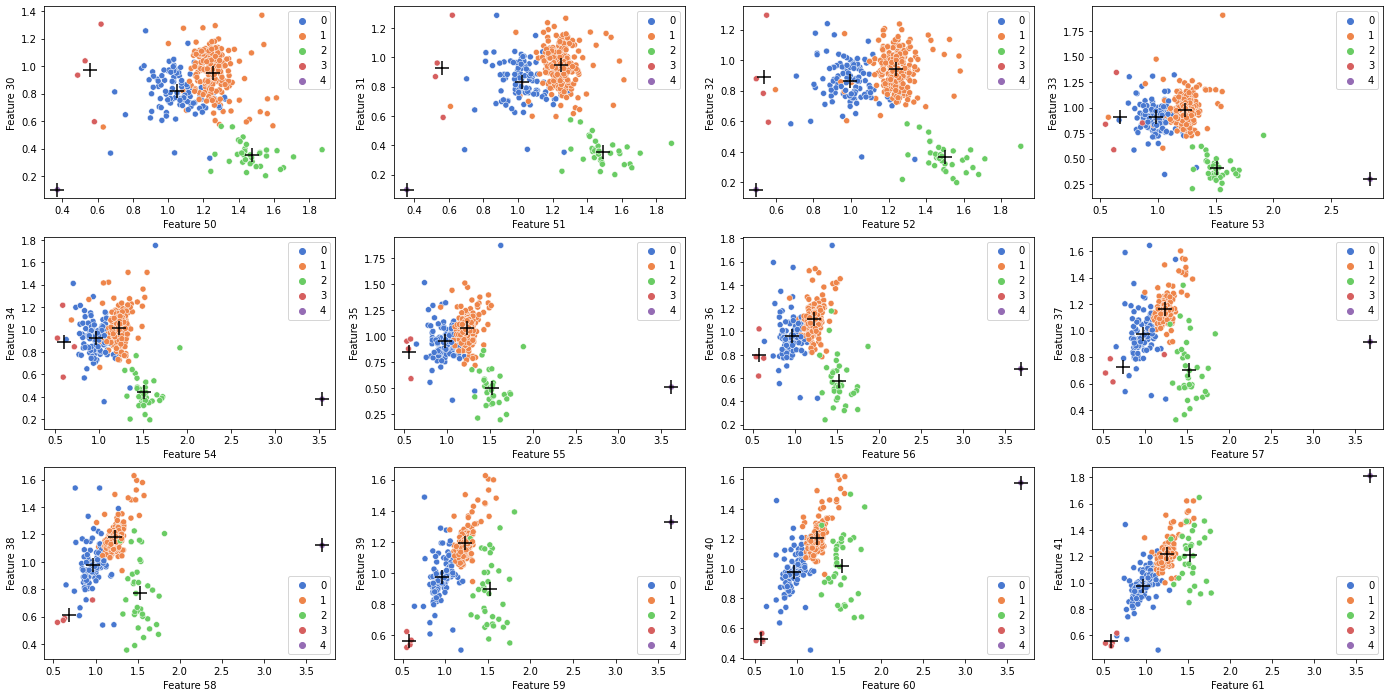

In [298]:
# Example visualization of clusters (2-D)
import seaborn as sns
nrows=3
ncols=4
debut=50
plt.figure(figsize=(6*ncols,4*nrows))
for i in range(debut,debut+12):
  j=i-debut+1
  plt.subplot(nrows,ncols,j)
  rcx=i
  rcy=i-20
  sns.scatterplot(x=X[:,rcx], y=X[:,rcy],palette='muted',hue=km[4].labels_)
  plt.scatter(x=km[4].cluster_centers_[:,rcx],y=km[4].cluster_centers_[:,rcy],color='black', marker='+',s=200)
  plt.xlabel('Feature {}'.format(rcx))
  plt.ylabel('Feature {}'.format(rcy))

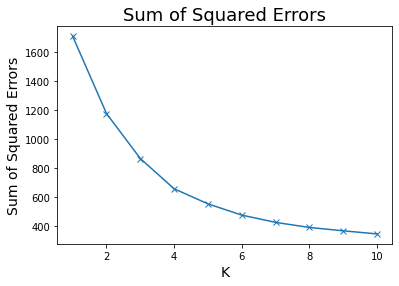

In [92]:
plot_optimal_k(k_range, sse, 'Sum of Squared Errors')

The elbow graph does not show an obvious kink bend point in the graph, but 4 or 5 clusters are close to the elbow point.

## b. Plot for each cluster

### 1-- Initial 3 clusters

In [315]:
# plots clusters
def draw_clusters(X, y_pred, centers, n_rows=1, n_cols=1,xlab=None,oldticks=None,newticks=None):
  plt.figure(figsize=(6*n_cols,4.5*n_rows))
  n_clusters = np.unique(y_pred).shape[0]
  for j in range(n_clusters):
    plt.subplot(n_rows,n_cols,j+1)
    jcluster = X[y_pred==j]
    for i in range(jcluster.shape[0]):
      plt.xlabel(xlab, fontsize=14)
      plt.ylabel('Energy consumption', fontsize=14)
      plt.ylim(0,X.max())
      plt.plot(jcluster[i,:],)
    plt.plot(centers[j],lw=4, color='black', label='Centroid')
    plt.xticks(oldticks,newticks)
    plt.legend()
    plt.title('Cluster: {}, Number of Clients: {}'.format(j, jcluster.shape[0]), fontsize=18)
  plt.tight_layout(pad=3.0)

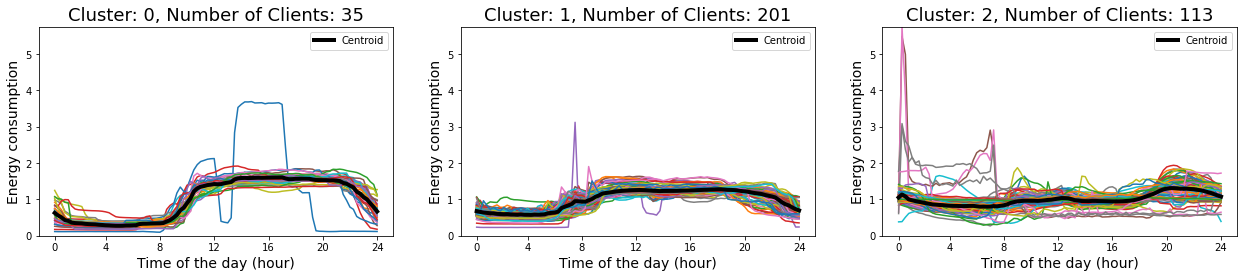

In [323]:
k=3
nrows=1
ncols=k
oldticks = [0,15,31,47,63,79,95]
newticks = [0,4,8,12,16,20,24]
draw_clusters(X, km[k-1].labels_, km[k-1].cluster_centers_, nrows, ncols,'Time of the day (hour)',oldticks,newticks)

It looks like the 3 clusters captured most of the similar examples in the data. for example, <br> 

-- The 35 clients in the first cluster (label 0) have a very low energy consumption during night hours, but ramp up from 6:00 to 8:00, and stay at a very high but constant level of consumption (approximately close to 2.0) all the way until 22:00; <br>
-- The 201 clients in the second cluster (label 1) have a low consumption from 1:00am to 6:00am, ramp up from 5:30am to 7:30am and stay at a high but constant level of consumption of approximately 1.1 from 7:30am until 22:00. <br>
-- The 113 clients in the third cluster (label 2) includes the clients with quite uniform but low energy consumption during the day but higher energy consumption during evening hours from 7:00pm to 1:00am. <br> 
However, there are some exceptions in each cluster. For example, in the third cluster, there are some huge variations in the overnight consumption, and in the second cluster, one customer seems to stand out.<br>
We can increase the number of clusters to capture these outliers.

### 2-- Adjust the number of clusters (n_cluster=4)

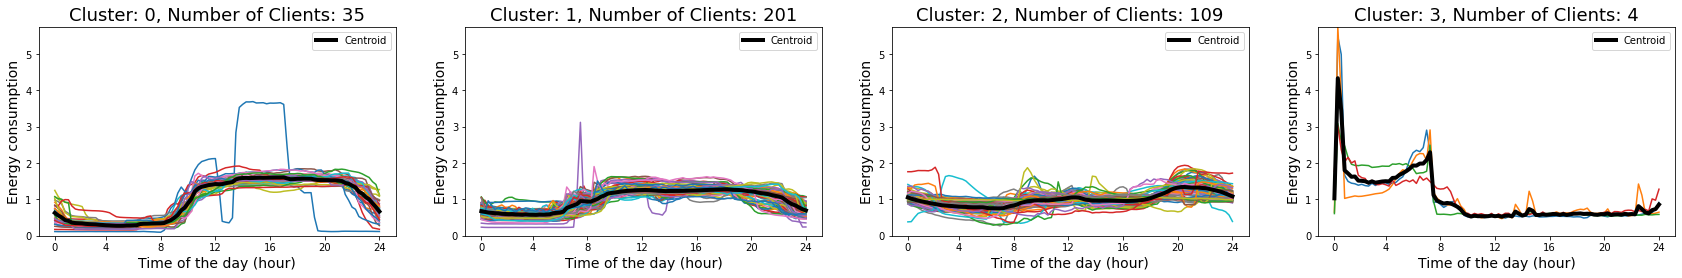

In [324]:
k=4
nrows=1
ncols=4
draw_clusters(X, km[k-1].labels_, km[k-1].cluster_centers_, nrows, ncols,'Time of the day (hour)',oldticks,newticks)

### 3-- Adjust the number of clusters (n_cluster=5)

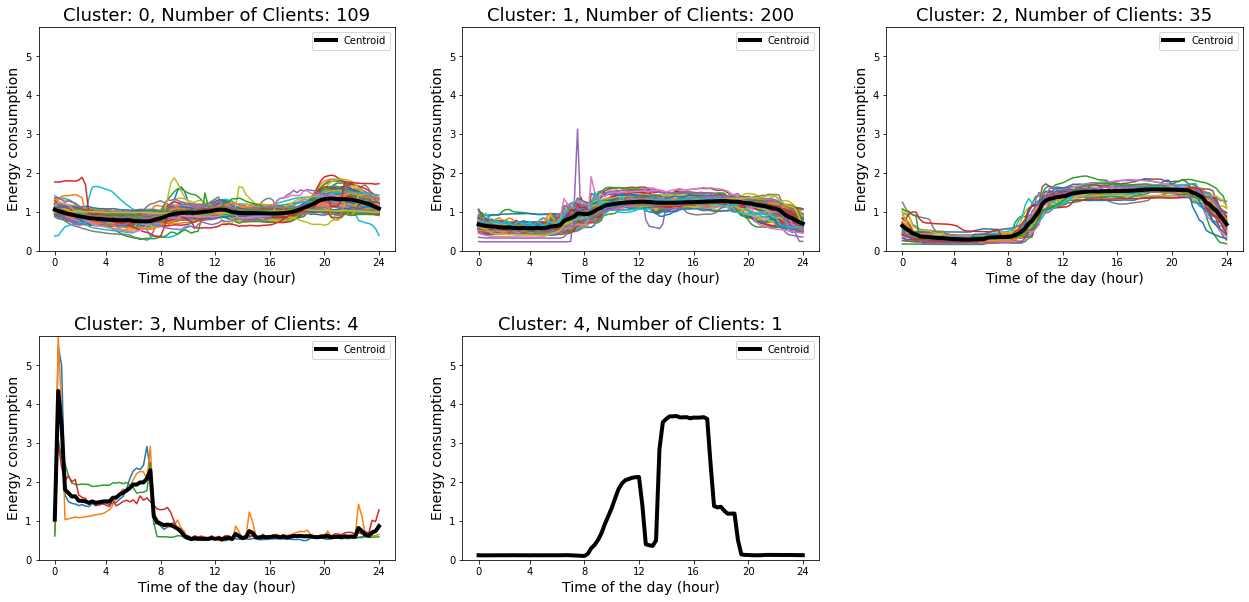

In [325]:
k=5
nrows=2
ncols=3
draw_clusters(X, km[k-1].labels_, km[k-1].cluster_centers_, nrows, ncols,'Time of the day (hour)',oldticks,newticks)

The visualization of the clusters indicate that 5-cluster model is able to segment the outlier clients. <br>
-- Besides the 3 clusters identified in the initial 3-cluster model, this 5-cluster model also identified additional 2 clusters that have quite unique patterns.<br>
-- Cluster with label 2 separates 4 clients with unique consumption pattern during the day, which have an extreme high peak at around midnight and arround 7am, and remain relatively high consumption throughout the night. <br>
-- There is only one client in the cluster with label 4 - this is a very special client with unique energy consumption pattern: extremely high consumption in the afternoon hours and also very high in the late morning hours. The client identification is:

In [301]:
# ID of the Unique client in cluster 4:
np.where(km[4].labels_==4)[0][0]

92

In [303]:
sum(data['MT_092']==0), sum(data['MT_092']>0), data['MT_092'].shape

(2923, 67157, (70080,))

In [305]:
data[data['MT_092']==0].index

Index(['2013-01-01 00:15:00', '2013-01-01 00:30:00', '2013-01-01 00:45:00',
       '2013-01-01 01:00:00', '2013-01-01 01:15:00', '2013-01-01 01:30:00',
       '2013-01-01 01:45:00', '2013-01-01 02:00:00', '2013-01-01 02:15:00',
       '2013-01-01 02:30:00',
       ...
       '2013-01-31 08:30:00', '2013-01-31 08:45:00', '2013-01-31 09:00:00',
       '2013-01-31 09:15:00', '2013-01-31 09:30:00', '2013-01-31 09:45:00',
       '2014-03-30 01:00:00', '2014-03-30 01:15:00', '2014-03-30 01:30:00',
       '2014-03-30 01:45:00'],
      dtype='object', length=2923)

This client is likely a new client, with about one month in 2013 (2923 15min periods = 2923/96=30 days, mojority in January) with zero energy consumption.

## Analysis on a single client. 

### **-- a. Determine the optimal value of k ( number of clusters).**


#### **Client "MT_018"**

In [103]:
# Choose a random client and reshape the data

client = 'MT_018'
oneClient = data_13_14[client]
X018 = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X018.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 
X018 = np.array([X018[i]/X018[i].mean() for i in range(len(X018))])
print(X018.shape)

(730, 96)


##### ***Elbow graph***

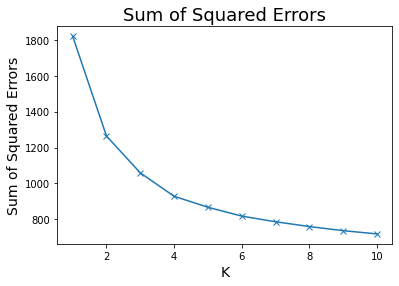

In [122]:
# Plot the elbow graph
k_range = range(1,11)
km018 = [KMeans(n_clusters=k, random_state=42).fit(X018) for k in k_range]
sse018 = [model.inertia_ for model in km018]
  
plot_optimal_k(k_range, sse018, 'Sum of Squared Errors')

The elbow grpah shows that k=4 may be a good number of clusters.

##### ***Silhoutte Coefficient***

In [124]:
# Silhouette Coefficients
silcoef_mt018 = [silhouette_score(X018, model.labels_, metric='euclidean') for model in km018[1:]]

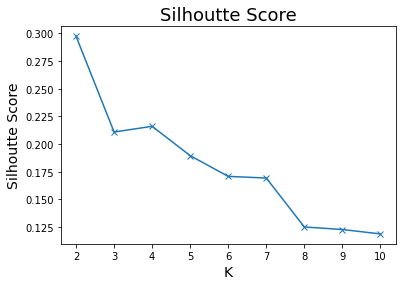

In [109]:
plot_optimal_k(range(2,len(km018)+1), silcoef_mt018, 'Silhoutte Score')

The **silhoutte coefficient scores** from models using different number of clusters indicate that the highest score is ***0.299*** with **2 clusters**. With increasing number of clusters, the silhoutte coefficient decreases, indicating increasing chance of overlapping between clusters and worse clustering.<br>
Visually, k = 4 seems to have the a better score than other k values (except 2)
Let's visualize the clusters for the 3 highest silhoutte coefficients.

##### ***Visualize clusters***

n_clusters=2, silhoutte score=0.29746710322530745


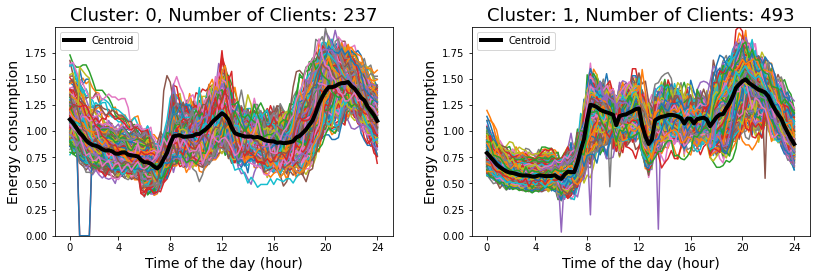

In [329]:
k = 2
print('n_clusters={}, silhoutte score={}'.format(k, silhouette_score(X018,labels=km018[k-1].labels_, metric='euclidean')))
nrows=1
ncols=2
draw_clusters(X018, km018[k-1].labels_, km018[k-1].cluster_centers_, nrows, ncols,'Time of the day (hour)',oldticks,newticks)

The **silhoutte coefficient scores** from KMeans model of 2-cluster shows the model group the consumption of days for client MT_018 into two clusters: <br>
-- The cluster with label 0 has a decreasing night consumption and lower consumption during the day than those in the cluster with label 1. <br>
-- The cluster with label 1 has low and somewhat constant energy consumption at night, high consumption starting from 7/8am, and has a dip at lunch hour, and highest consumption at 8:00pm.


n_clusters=3, silhoutte score=0.21086336518952414


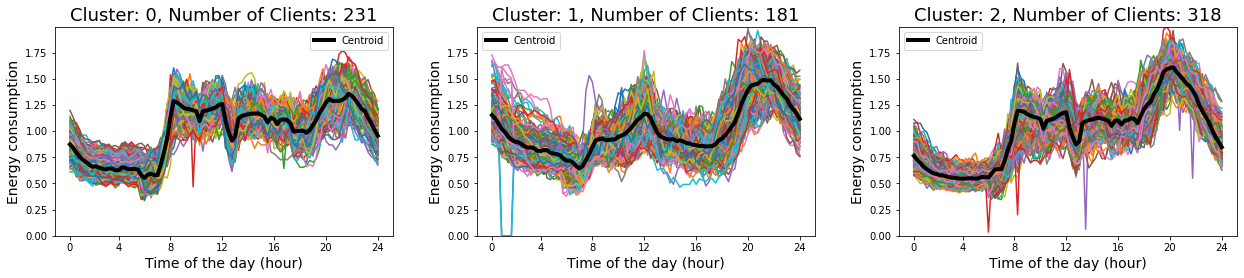

In [330]:
k = 3
print('n_clusters={}, silhoutte score={}'.format(k, silhouette_score(X018,labels=km018[k-1].labels_, metric='euclidean')))
nrows=1
ncols=3
draw_clusters(X018, km018[k-1].labels_, km018[k-1].cluster_centers_, nrows, ncols,'Time of the day (hour)',oldticks,newticks)

With k=3, clusters with labels 0 and 2 are somewhat similar, the main difference lies at the the peak amount of consumption at 8:00pm.

n_clusters=4, silhoutte score=0.21602301805582833


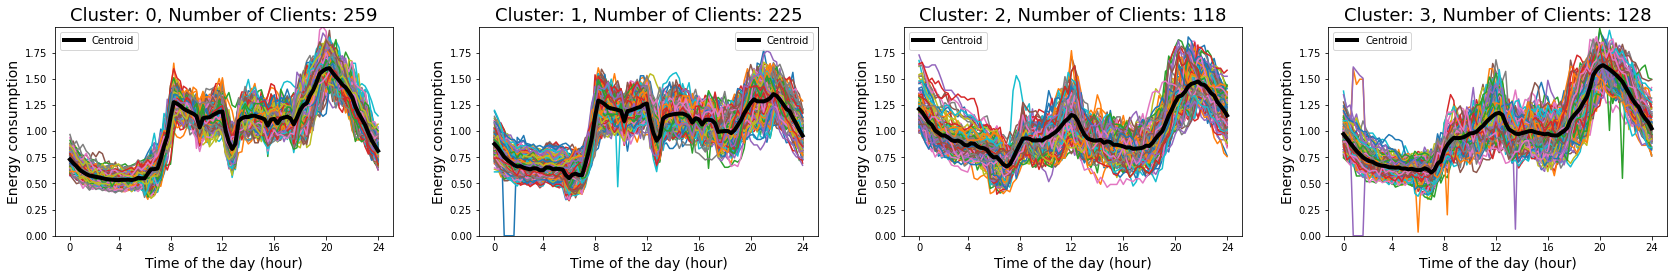

In [332]:
k = 4
print('n_clusters={}, silhoutte score={}'.format(k, silhouette_score(X018,labels=km018[k-1].labels_, metric='euclidean')))
nrows=1
ncols=4
draw_clusters(X018, km018[k-1].labels_, km018[k-1].cluster_centers_, nrows, ncols,'Time of the day (hour)',oldticks,newticks)

With n_clusters=4, clusters with labels 0 and 2 have similar patterns except the peak location and and peak height, and so do clusters with labels 1 and 3. 

##### ***Silhouette Analysis***

In [219]:
# Define plotting function
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

# plot silhouette coefficients for all instances in each cluster
def plot_silhouette_coeffs(X, y_pred, silh_score, k, nrows=1, ncols=1,k1=2, k1p = 2):  
  """ Plot silhouette coefficients for all instances
    X: array
    y: predicted labels
    silh_score: average silhouette coefficient of the clustering model
    k: number of clusters
    nrows, ncols: the number of rows and coloumns of the subplots
    k1: the smallest k value when predicting silhouette coefficient
    k1p: the start k value for plotting
  """
  silh_coeffs = silhouette_samples(X, y_pred)
  padding = len(X) // 30
  pos = padding
  ticks = []
  for i in range(k):
    coeffs = silh_coeffs[y_pred==i]
    coeffs.sort()
 
    color = plt.cm.tab20(i%k) # One color for each cluster
    plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ticks.append(pos + len(coeffs) // 2) # tick location
    pos += len(coeffs) + padding
  plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
  plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
  
  plt.gca().set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
  # plt.tick_params(labelbottom=False)
  if k in range(k1p, k1p + ncols*nrows, ncols):
      plt.ylabel("Cluster", fontsize=14)

  if k in range(k1+nrows*(ncols-1), k1+nrows*ncols+1) or nrows==1: # last row
    plt.xlabel("Silhouette Coefficient", fontsize=14)
  else:
    plt.tick_params(labelbottom=False) 

  plt.axvline(x=silh_score, color="red", linestyle="--")
  plt.title("k={}".format(k), fontsize=16)

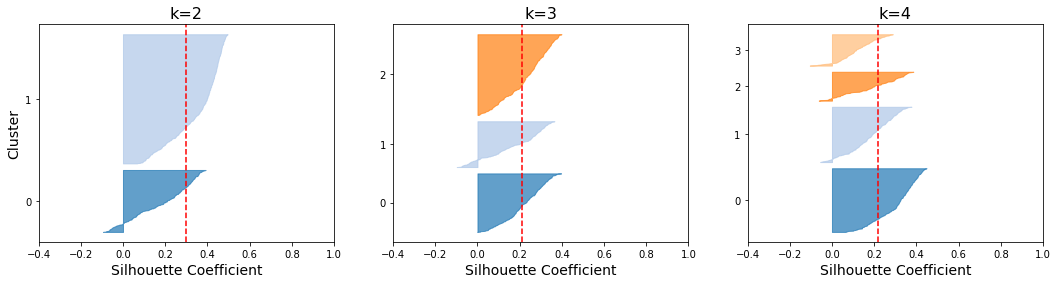

In [223]:
# plot silhouette coefficients analysis
nrows=1
ncols=3
plt.figure(figsize=(6*ncols, 4*nrows))
k1 = km018[0].n_clusters # first k value
k1p = 2
for k in range(k1p,5):
    plt.subplot(nrows, ncols, k - k1p + 1 )
    y_pred = km018[k-k1].labels_
    silh_score_k = silhouette_score(X018, km018[k-k1].labels_)
    plot_silhouette_coeffs(X018, y_pred, silh_score_k, k, nrows, ncols, k1, k1p)

***-- The silhouette scores plots indicate that most of instances in all clusters are larger than the silhouette score for corresponding number of clusters when k=2, 3, and 4.*** <br>
***-- The silhoueete score is the highest when k=2, and the number of the instances (here clients) in the cluster at index 1 is is more than twice the size at index 0. When k=3, the average score is lower, however, the difference in cluster size is  smaller. When k=4, clusters have very different sizes (the largest is over twice the size of the smalles).***<br><br>
**In conclusion, it seems like a good idea to use K=2 divide daily consumptions of the client MT_018 into two categories: The days with higher morning cunsumptions and days with higher evening consumtions.**

#### **Client "MT_100"**

Let's look at another client "MT_100"

In [232]:
client = 'MT_100'
oneClient = data_13_14[client]
X100 = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X100.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 
X100 = np.array([X100[i]/X100[i].mean() for i in range(len(X100))])
print(X100.shape)

(730, 96)


##### ***Silhoutte coefficient & Inertia***

In [119]:
km100 = [KMeans(n_clusters=k, random_state=42).fit(X100)
                for k in range(1, 15)]

In [54]:
sse_mt100 = [model.inertia_ for model in km100]

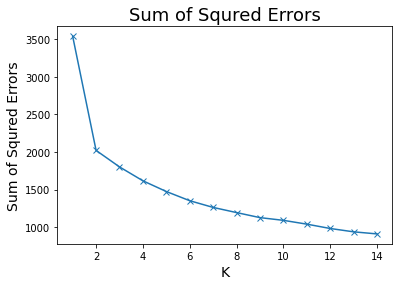

In [55]:
plot_optimal_k(range(1,15), sse_mt100, 'Sum of Squred Errors')

Elbow plot sees a large reduction in SSE when k increases from1 to 2, however, the reduction is not very dramatic with further increasing k. 

In [130]:
# Silhouette Coefficients
silcoef_mt100 = [silhouette_score(X100, model.fit(X100).labels_, metric='euclidean') for model in km100 if model.n_clusters!=1]

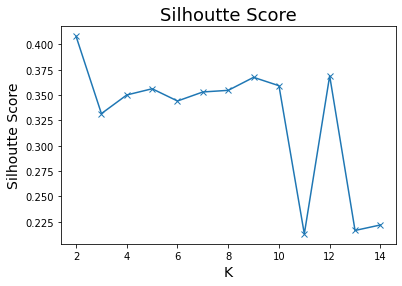

In [57]:
plot_optimal_k(range(2,15), silcoef_mt100, 'Silhoutte Score')

For client MT_100, when k=2, the algorithm has the highest silhouette score, suggesting a likely good number. Some k values, i.e., k=5, 9 and 12 also show a local maxima, which the elbow graph did not indicate. <br>
Let's plot each cluster for k=2, 5, 9 and 12 to see which number is ideal

##### ***Visualize clusters***

n_clusters=2, silhoutte score=0.4080005757649622


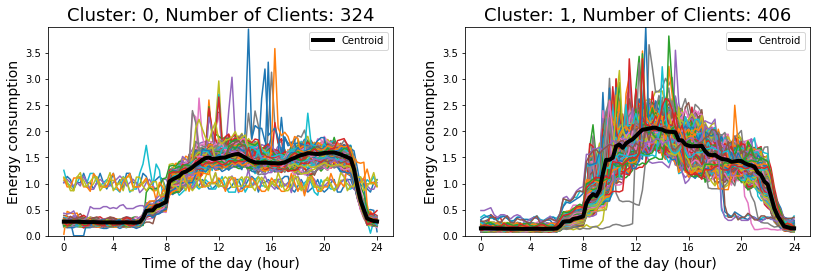

In [333]:
k=2
print('n_clusters={}, silhoutte score={}'.format(k,silhouette_score(X100,labels=km100[k-1].labels_, metric='euclidean')))
nrows=1
ncols=2
draw_clusters(X100, km100[k-1].labels_, km100[k-1].cluster_centers_, nrows, ncols,'Time of the day (hour)',oldticks,newticks)

There seems to have some days with flat consumption that did not get separated using k=2. Most likely these are outliers, like meter mulfunction or special occasions. When k=2, the days for thei client MT_100 is classified into two categories: days with relatively contant day and night consumptions and days with high consumtion morning consumptions. 

n_clusters=5, silhoutte score=0.3562201337757996


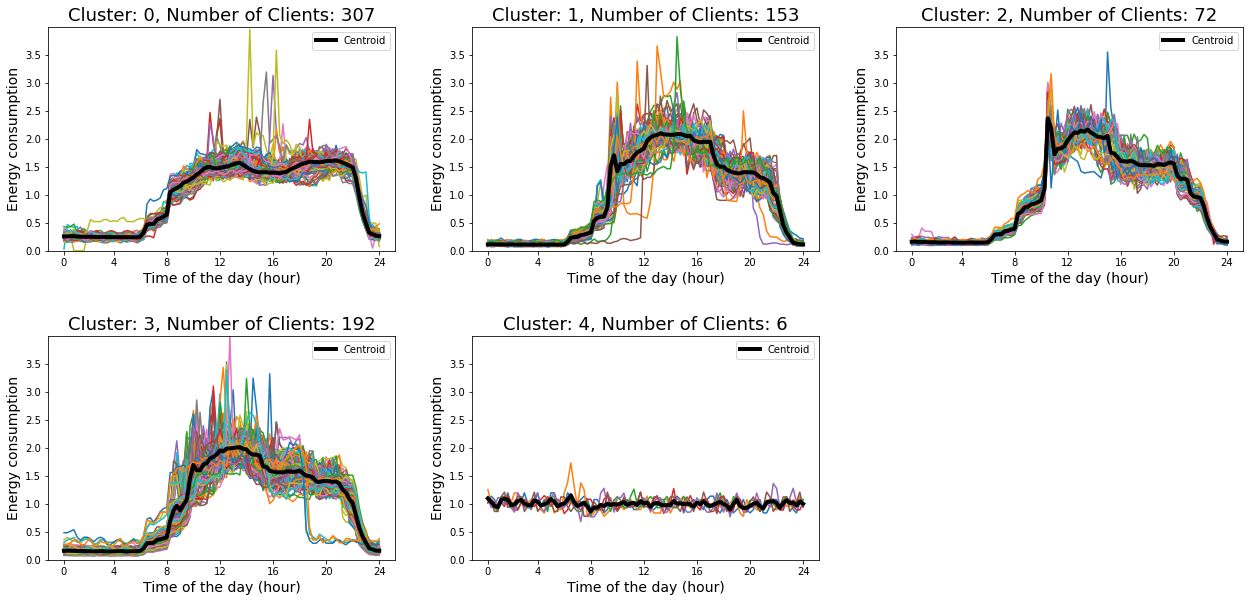

In [334]:
k = 5
nrows=2
ncols=3
print('n_clusters={}, silhoutte score={}'.format(k,silhouette_score(X100,labels=km100[k-1].labels_, metric='euclidean')))
draw_clusters(X100, km100[k-1].labels_, km100[k-1].cluster_centers_, nrows, ncols,'Time of the day (hour)',oldticks,newticks)

When k=5, KMeans algorithm is able to separate the flat consumption days from othe days. 

n_clusters=9, silhoutte score=0.367483146295541


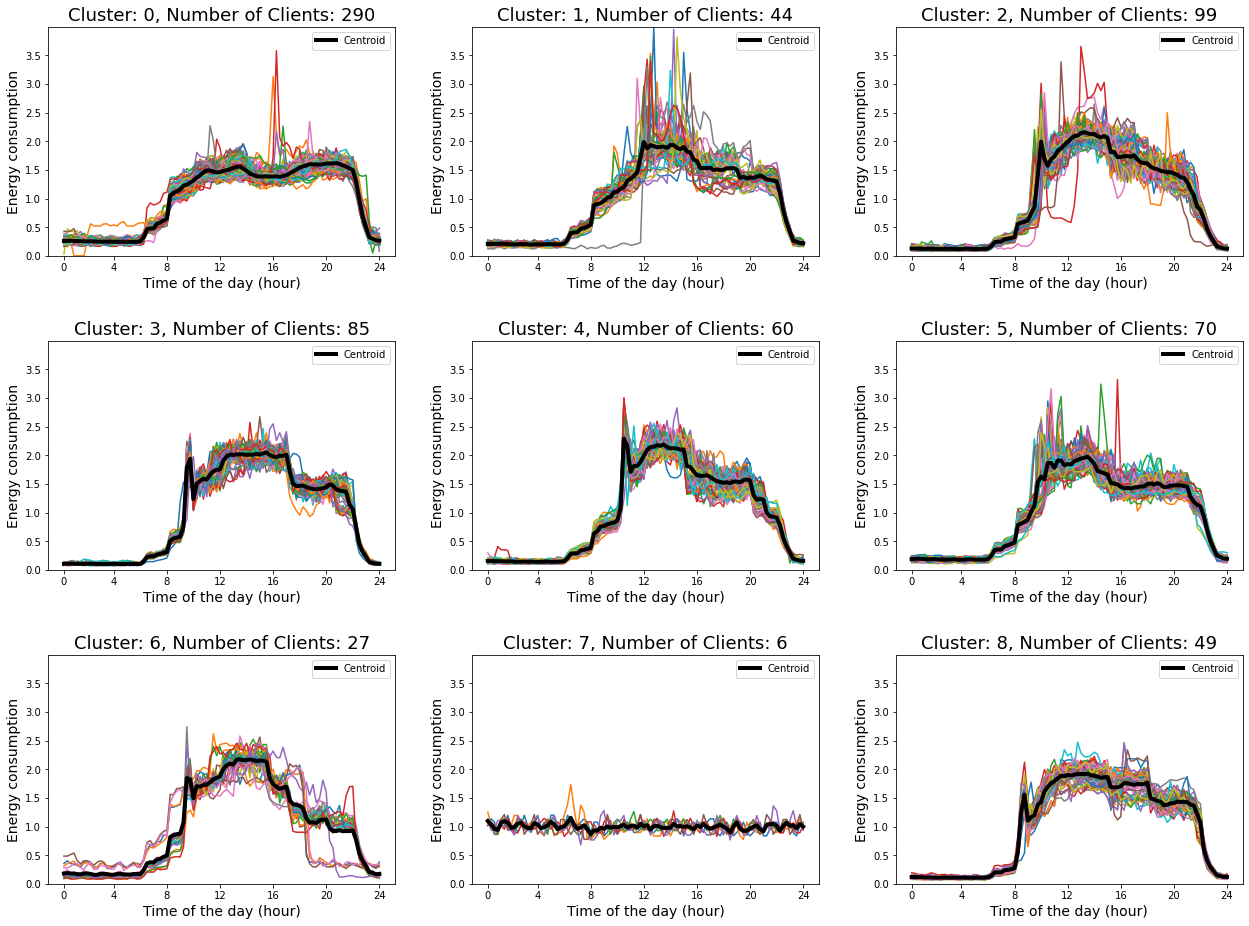

In [335]:
k = 9
nrows=3
ncols=3
print('n_clusters={}, silhoutte score={}'.format(k,silhouette_score(X100,labels=km100[k-1].labels_, metric='euclidean')))
draw_clusters(X100, km100[k-1].labels_, km100[k-1].cluster_centers_, nrows, ncols,'Time of the day (hour)',oldticks,newticks)

When k=9, the daily consumptions are grouped into more categories. Many of these categories look similar but with some diference in the location and height of peaks.

n_clusters=12, silhoutte score=0.3689437040142711


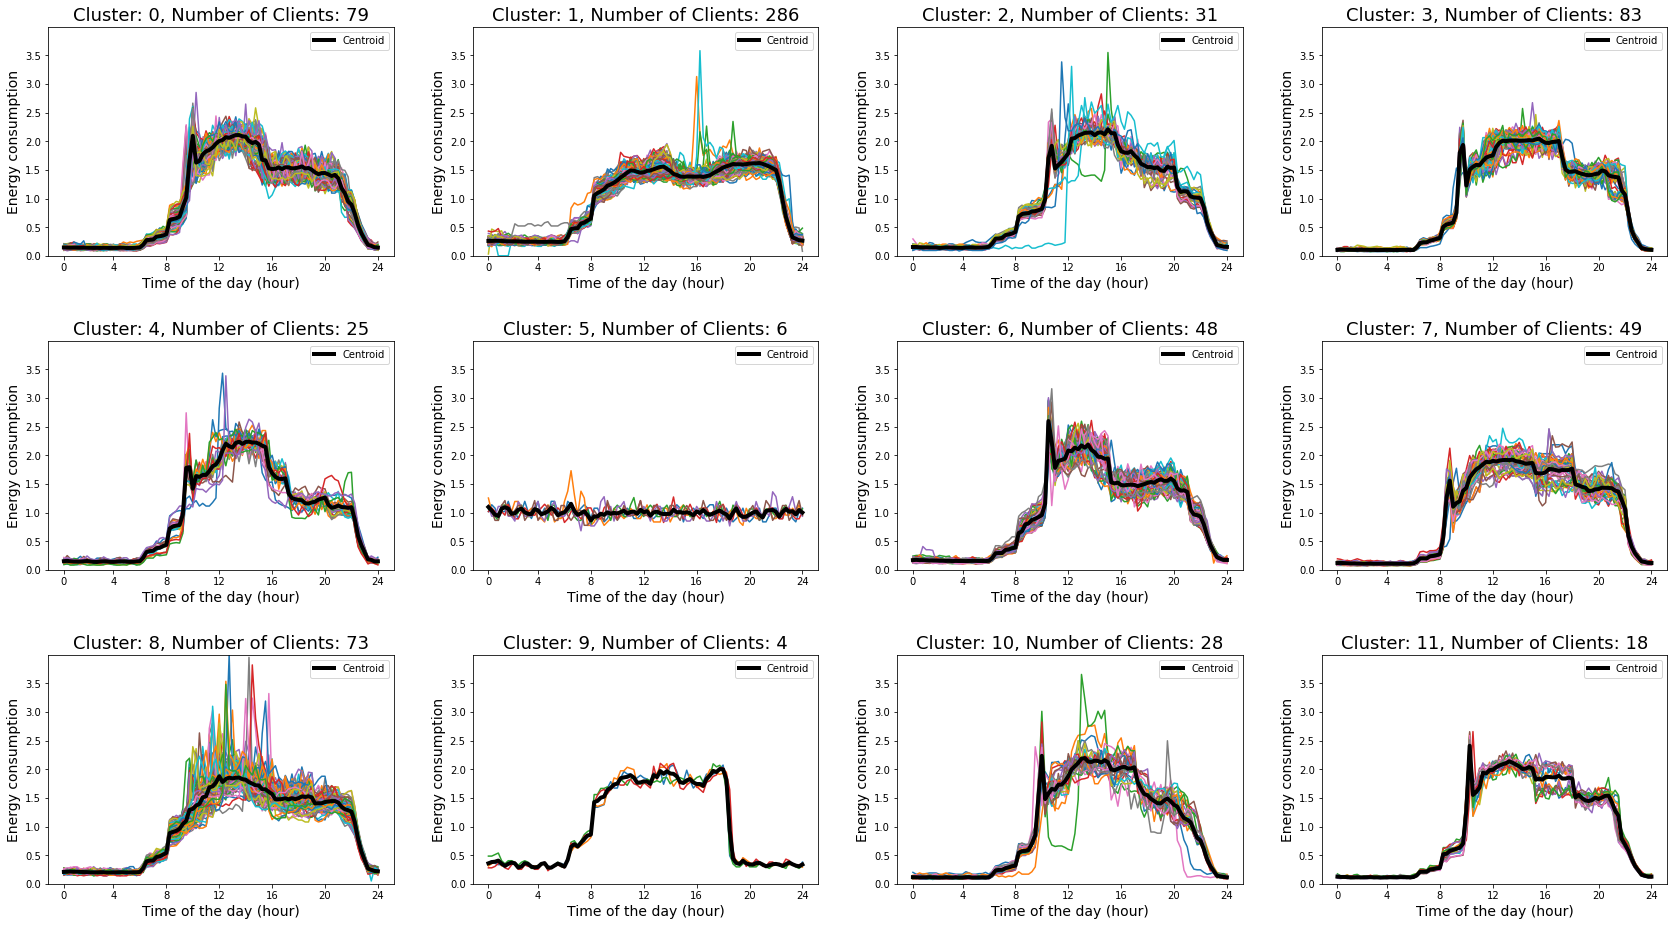

In [336]:
k = 12
nrows=3
ncols=4
print('n_clusters={}, silhoutte score={}'.format(k,silhouette_score(X100,labels=km100[k-1].labels_, metric='euclidean')))
draw_clusters(X100, km100[k-1].labels_, km100[k-1].cluster_centers_, nrows, ncols,'Time of the day (hour)',oldticks,newticks)

The distinct days (cluster label 9) with constant consumption from 6:00pm -6:00am can be separated when k=12, with silhoutte coefficient of 0.369. <br>
For this client "MT_100", it seems k=12 is able to group similar patterns into corresponding clusters. These clusters each has some what distinct pattern of energy consumptions during the 24-hour period. ***Cluster with label 1*** has the most days, Where clusters 5 and 9 have only 6 and 4 days. These are most likely outliers. So **when k=12 the algorithm is able to separate most outliers but also many clusters are similar to each other, while when k=5, it is able to separate the most significant outliers.**

##### ***Silhoutte Analysis***

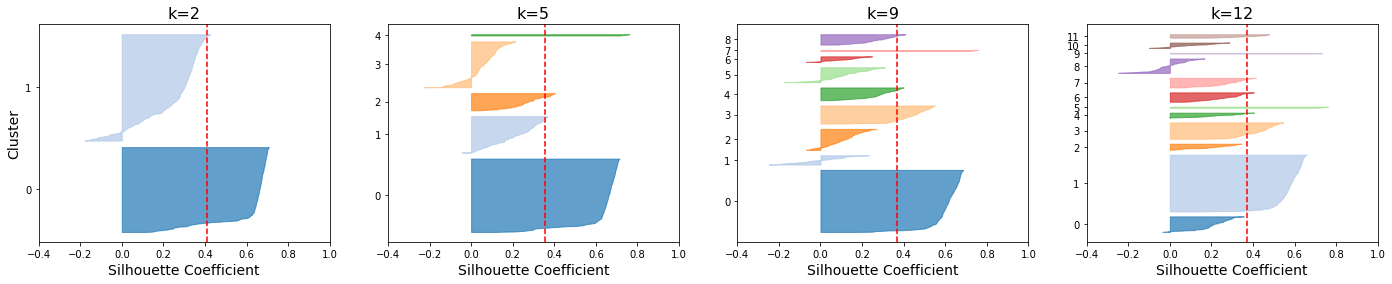

In [222]:
# plot silhouette coeffs
nrows=1
ncols=4
plt.figure(figsize=(6*ncols, 4*nrows))
k1 = km100[0].n_clusters # first k value in the kmeans model
if k1 == 1:
  k1s = 2
else:
  k1s = k1
k1p = 2 #first k value for plotting
g=1
for k in (2,5,9,12):
  plt.subplot(nrows, ncols, g)
  y_pred = km100[k-k1].labels_
  silh_score_k = silcoef_mt100[k-k1s]
  plot_silhouette_coeffs(X100, y_pred, silh_score_k, k, nrows, ncols, k1, k1p)
  g=g+1

Silhouette analysis reveals that most of seemingly "good" k values (2,5,9,12), based on the highest average silhouette scores and elbow graph, do not have the good clustering results:<br>
***-- There are several bad clusters within the "good" k values. For example, when k=5, most of the instances at indices 1, 2, and 3 have a lower score than overall silhouette score; same goes for most instances at all indices except for 0, 3 and 7 when k=9 and at all indices except for 1,3,5,9 and 11 when k=12.*** <br>
***-- The number of instances in each cluster is very uneven when k=5, 9 and 12.*** <br>
***-- When k=2, all instances at index 0 have the silhouette score well above the overall score , while only a few do at index 1.*** <br><br>
**In conclusion, k=2 is a relatively good number for clustering the daily consumtipn pattern for client MT_100. NONE of other k values based on the analyses, however, thes  other K values are able to separate outliers.**

#### What Do I understand about the clusters?

***-- For both clients MT_018 and MT_100, using k=2 is a good idea in grouping the daily consumption patterns.***<br>
***-- For client MT_018,*** daily energy consumption can be clustered into two categories: <br>
  1) Decreasing consumption from 10:00pm to 6:00am next day, increasing in the morning consumption until noon, relatively constant in the afternoon and increasing consumption until a high peak at 10:00pm. <br>
  2) Realtively constant night consumption, increasing sharply at 8:00am and staying hgih the whole morning with a small dip at likely coffee break at 10:00am, then with a deep dip at lunch hour (12-12:30). Afternoon consumption is constant and lower than morning consumption until 6:00pm, then the consumption increases to its peak at 10:00pm and then decreases. <br>
***-- For client MT_100, KMeans algorithm seems unable to produce good clusters but k=2 seems relatively good with silhouette score of 0.41.*** It seems the daily comsumption of this client has ***multiple outliers/abnormal instances***. From the plots of clusters, many instances have similar patterns, ***other clustering algorithms should be tried*** to more properly group them into clusters or confirm the outliers.


### **--b. Based on the above analysis, here are my understanding about the customers**

In [83]:
X018[km018[0].labels_==0].shape[0]/X018[km018[0].labels_==1].shape[0]

0.48073022312373226

In [86]:
#Cluster size ratios
ratio018_k2 = X018[km018[0].labels_==0].shape[0]/X018[km018[0].labels_==1].shape[0]
print('MT_018 cluster size ratio when k=2: {}'.format(ratio018_k2))
ratio100_k2 = X100[km100[1].labels_==0].shape[0]/X100[km100[1].labels_==1].shape[0]
print('MT_100 cluster size ratio when k=2: {}'.format(ratio100_k2))

MT_018 cluster size ratio when k=2: 0.48073022312373226
MT_100 cluster size ratio when k=2: 0.7980295566502463


For ***clien MT_018***, the cluster size with label 0 (first cluster) is about 48% of the size of the cluster with label 1, suggesting <br>
1) In approximately 2/3 of the days in a year this client's energy usage follows the pattern that includes a small shallow dip at 10:00am and deeper dip at noon. This may suggest that this client has a regular schedule for a 15-min coffee break and a 30-min lunch break. <br>
2) In the remaining 1/3 of the days this client may not have time for the breaks. This could be due to urgent tasks or the need to meet deadlines. <br>
3) The high evening engergy consumption in both clusters suggests the busiest time in the day is 10:00pm.<br><br>
For ***client MT_100***, the cluster size with label 0 is about 80% of the size of the cluster with label 1, suggesting:<br>
1) In approximately 44% of the days in a year, the client has a relative constant energy consumptions thoughout the day from 8:00am to 10:00pm.<br>
2) In the remaining 56% of the days, the energy cncumption is much higher from 8:00am to 3:00pm than after 3:00pm. This may suggest this client uses resources in the first shift than in the second shift. <br>
3) This client does not have sheduled breaks.<br>
4) There are certain days in both clusters that seem like outliers. For example, in the first cluster, energy consumptions in 6 days were constant the entire day, suggesting this client stopped normal activities - due to machine overhaul, schedualed downtime, or malfunction of energy meters. <br>

Other thoughs: <br>
-- ***Different clustering performance evaluation methods do not always agree with each other***, but from the two clients that we analyzed, the elbow graph and overall silhoutte coeffient genrally gave consistent suggestions of good k values. If possible, ***visualizing the clusters may help assess the performance of the clustering method***. <br>
-- Silhouette analysis gives more informative visualization by plotting sorted silhouette scores for each instance in each cluster using **silhouette diagram**. This diagram can greatly help ***evaluate the performance of clustering algorithm and parameters*** which sometimes may mislead by using inertia elbow graph or overall silhoutte coefficient alone.

### ***Interpret it with timelines in week and month.***
As analyzed above, the clients can be grouped into three clusters based on daily energy consumption behavior; and for individual clients MT_018 and MT_100, the daily usage can be put into two clusters. <br> 
To further examine the energy consumtpion behavior, here we will analyze with weekly and monthly consumption perspective to see if there is any distinct pattern of behaviors.

In [139]:
# Getting average day curves per client
data_13_14['date'] = data_13_14.index.map(lambda x:x[:10])
groupbydate = data_13_14.groupby('date')
dailydata = groupbydate.agg('mean')
dailydata.shape

(731, 349)

#### **All clients weekly**

In [140]:
# Getting average weekly curves per client
dailydata['weekday'] = pd.to_datetime(dailydata.index).weekday
groupbyweekday = dailydata.groupby('weekday')
datawkday = groupbyweekday.agg('mean')
datawkday = datawkday/datawkday.mean()
datawkday.shape

(7, 349)

In [141]:
Xw = np.array(datawkday.T)
print(Xw.shape)
Xw[:1]

(349, 7)


array([[0.97247474, 1.06764511, 1.1021224 , 1.04347071, 1.0640678 ,
        0.87673952, 0.87347972]])

In [154]:
k_range = range(1,11)
kmwk = [KMeans(k, random_state=42).fit(Xw) for k in k_range]
ssewk = [model.inertia_ for model in kmwk]
silcoefwk = [silhouette_score(Xw,model.labels_) for model in kmwk if model.n_clusters!=1]

print(len(ssewk), len(silcoefwk))

10 9


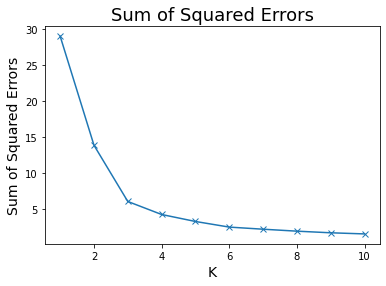

In [155]:
plot_optimal_k(k_range,ssewk)

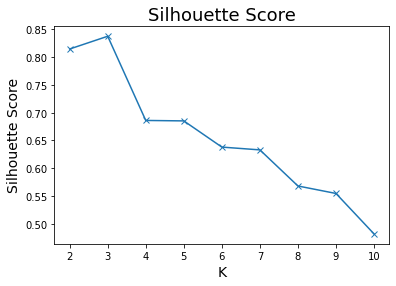

In [156]:
plot_optimal_k(k_range[1:],silcoefwk,'Silhouette Score')

Both the intertia elbow graph and Silhouette Coefficient graph sugest that k=3 may be a good number of clusters.

##### ***Plot clusters***

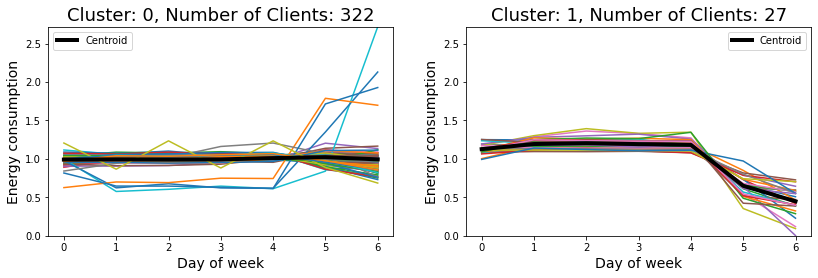

In [158]:
k = 2
nrows = 1
ncols = 2
draw_clusters(Xw, kmwk[k-1].labels_, kmwk[k-1].cluster_centers_, nrows, ncols,'Day of week')

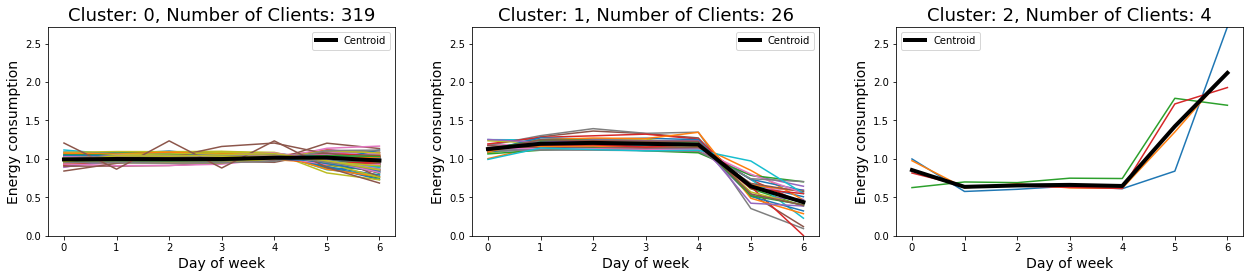

In [159]:
k = 3
nrows = 1
ncols = 3
draw_clusters(Xw, kmwk[k-1].labels_, kmwk[k-1].cluster_centers_, nrows, ncols,'Day of week')

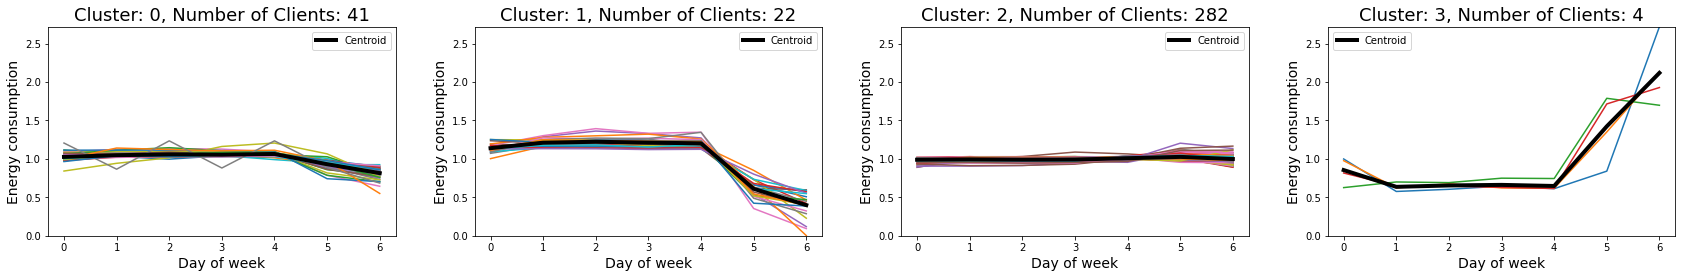

In [160]:
k = 4
nrows = 1
ncols = 4
draw_clusters(Xw, kmwk[k-1].labels_, kmwk[k-1].cluster_centers_, nrows, ncols,'Day of week')

It looks like k=3 is indeed a good number of clusters to group the clients. The KMeans(3) have separated the clients into ***3 clusters***: first cluster (label 0) are clients with constant energy consumption thoughout the week, the clients in the second cluster (label 1) have a normal weekday consumption but a low weekend consumption, and the third cluster is the clients having low weekday comsumption but a high weekend consumption. <br>
However, the ***first cluster is much larger*** than the second and the third clusters, suggeting most clients have constant weekly energy consumption.

##### ***Draw silhouette diagram***

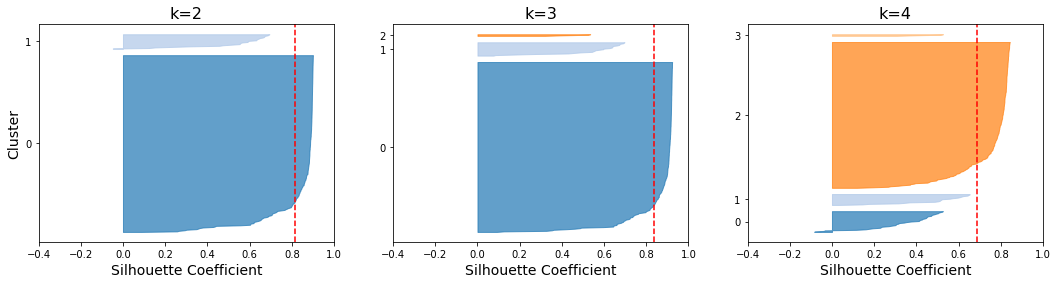

In [221]:
# plot silhouette coeffs
nrows=1
ncols=3
plt.figure(figsize=(6*ncols, 4*nrows))
k1 = kmwk[0].n_clusters # first k value in the kmeans model
if k1 == 1:  k1s = 2
else:  k1s = k1
k1p = 2 #first k value for plotting
g=1
for k in range(k1p,5):
  plt.subplot(nrows, ncols, g)
  y_pred = kmwk[k-k1].labels_
  silh_score_k = silcoefwk[k-k1s]
  plot_silhouette_coeffs(Xw, y_pred, silh_score_k, k, nrows, ncols, k1, k1p)
  g=g+1

The ***silhouette diagram*** shows that ***none of the k values*** is very good because the instances in the small clusters have lower silhouette scores than the overall cluster scores. However, the clients in these clusters are likely outliers - may suggest something, for example, ***when k=3, the clients in the cluster at index 1 may spend their weekend outside home and those at index 2 spend only weekend in the place, and these clients may have several homes. Or The clients at index 1 does not open on weekend and at index 2 only open on weekend. This depends on the type of client (for example, residential or company)***

#### **All client monthly**

In [170]:
dailydata['day'] = pd.to_datetime(dailydata.index).day
groupbyday = dailydata.drop('weekday',axis=1).groupby('day')
datamday = groupbyday.agg('mean')
datamday = datamday/datamday.mean()
datamday.shape

(31, 349)

In [171]:
Xm = np.array(datamday.T)
Xm.shape

(349, 31)

In [175]:
k_range = range(1,15)
kmm = [KMeans(k, random_state=42).fit(Xm) for k in k_range]
ssem = [model.inertia_ for model in kmm]
silcoefm = [silhouette_score(Xm,model.labels_) for model in kmm if model.n_clusters!=1]

print(len(ssem), len(silcoefm))

14 13


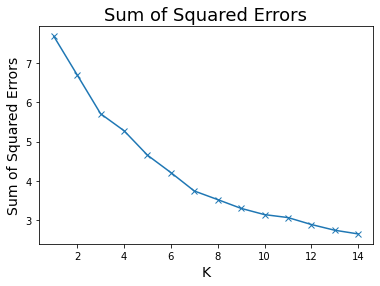

In [176]:
plot_optimal_k(k_range,ssem)

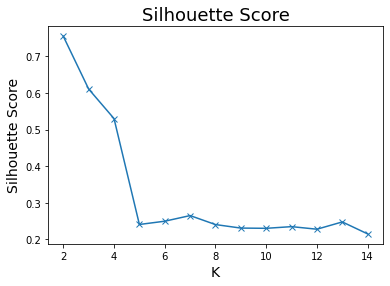

In [177]:
plot_optimal_k(k_range[1:],silcoefm,'Silhouette Score')

There is no dramatic reduction in inertia with increasing k as shown in the elbow graph (k=3 or 7 might be a good number), while silhouette score is decreasing all the way and dropping significantly at k=5, suggesting k=2 might be a good number. <br>
The intertia elbow graph and Silhouette Coefficient graph don't agree with each other in suggesting a good k number. 
Let's see the results when k=2,3,4.

##### ***Plot clusters***

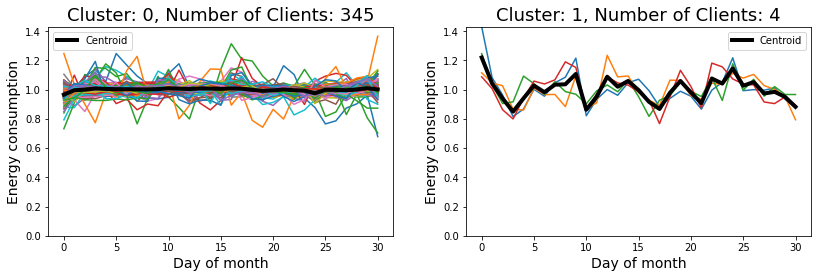

In [178]:
k = 2
nrows = 1
ncols = 2
draw_clusters(Xm, kmm[k-1].labels_, kmm[k-1].cluster_centers_, nrows, ncols,'Day of month')

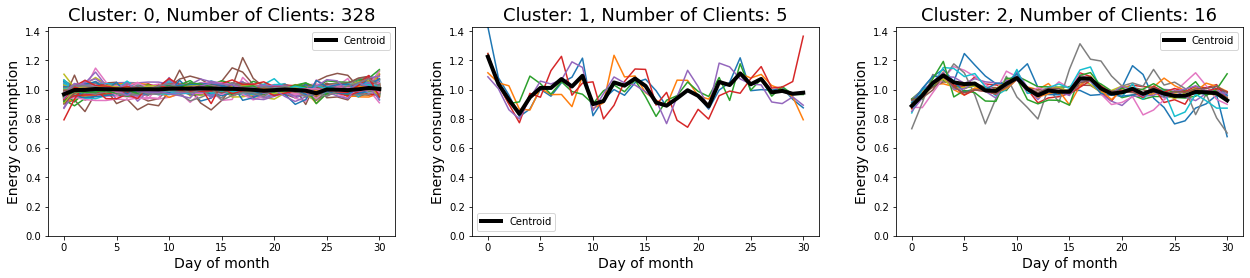

In [179]:
k = 3
nrows = 1
ncols = 3
draw_clusters(Xm, kmm[k-1].labels_, kmm[k-1].cluster_centers_, nrows, ncols,'Day of month')

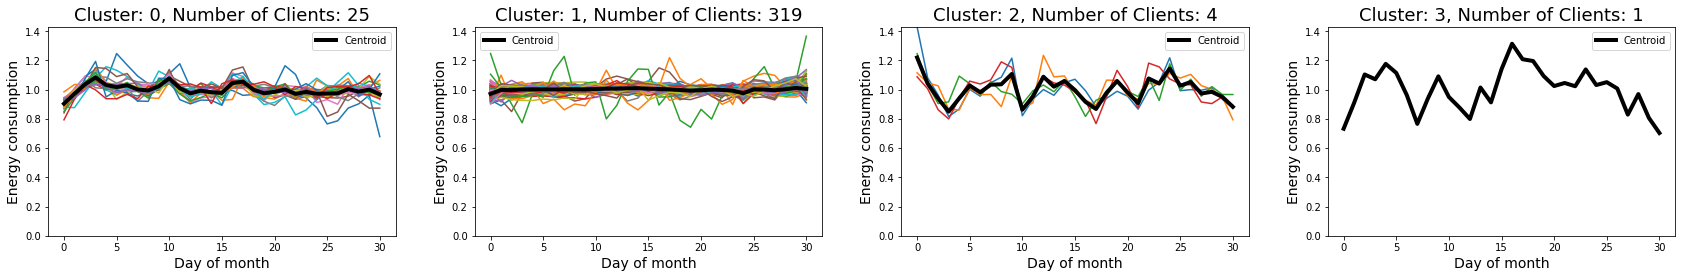

In [180]:
k = 4
nrows = 1
ncols = 4
draw_clusters(Xm, kmm[k-1].labels_, kmm[k-1].cluster_centers_, nrows, ncols,'Day of month')

There seem ***no distinct patterns*** in the monthly consumption for all clients. 

##### ***Draw silhouette diagram***

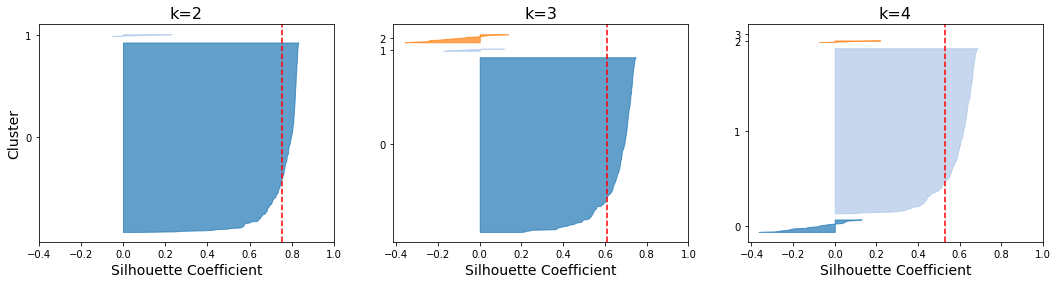

In [181]:
# plot silhouette coeffs
nrows=1
ncols=3
plt.figure(figsize=(6*ncols, 4*nrows))
k1 = kmm[0].n_clusters # first k value in the kmeans model
if k1 == 1:  k1s = 2
else:  k1s = k1
k1p = 2 #first k value for plotting
g=1
for k in range(k1p,5):
  plt.subplot(nrows, ncols, g)
  y_pred = kmm[k-k1].labels_
  silh_score_k = silcoefm[k-k1s]
  plot_silhouette_coeffs(Xm, y_pred, silh_score_k, k, nrows, ncols, k1, k1p)
  g=g+1

The silhouette diagram shows that none of the k values is good because the instances in the small clusters have lower silhouette scores than the overall cluster scores. Increasing k might separate some outliers into different clusters.

#### **Single client "MT_100" weekly**

In [182]:
# Get additional time related features: date and weeknr
dailydata['date'] = pd.to_datetime(dailydata.index)
day1 = min(dailydata['date'])
wkday1 = dailydata['weekday'][0] # the weekday number of the first date in the dataset
dailydata['weeknr'] = ((dailydata['date'] - day1 + np.timedelta64(wkday1,'D'))/np.timedelta64(7,'D')).astype(int)+1

In [183]:
mt_100 = dailydata[['MT_100','weekday','weeknr']]
# Tranform data from long to wide
mt_100 = mt_100.pivot(index='weeknr',columns='weekday', values='MT_100')
# Fill na cells with week mean value
mt_100 = mt_100.T.fillna(mt_100.T.mean()).T
X100w = np.array(mt_100)
X100w = np.array([X100w[i]/np.nanmean(X100w[i]) for i in range(len(X100w))])
X100w.shape

(105, 7)

In [184]:
k_range = range(1,15)
km100wk = [KMeans(k, random_state=42).fit(X100w) for k in k_range]
sse100wk = [model.inertia_ for model in km100wk]
silcoef100wk = [silhouette_score(X100w,model.labels_) for model in km100wk if model.n_clusters!=1]

print(len(sse100wk), len(silcoef100wk))

14 13


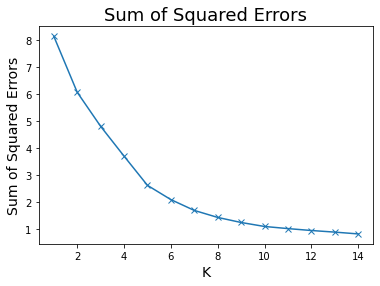

In [185]:
plot_optimal_k(k_range,sse100wk)

The intertia elbow graph suggest that k=5 may be a good number of clusters.

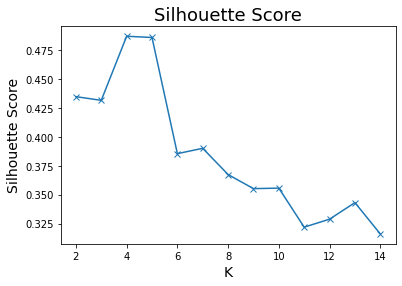

In [186]:
plot_optimal_k(k_range[1:],silcoef100wk,'Silhouette Score')

The Silhouette Coefficient graph suggests that k=4 or 5 may be a good number of clusters.

##### ***Plot clusters***

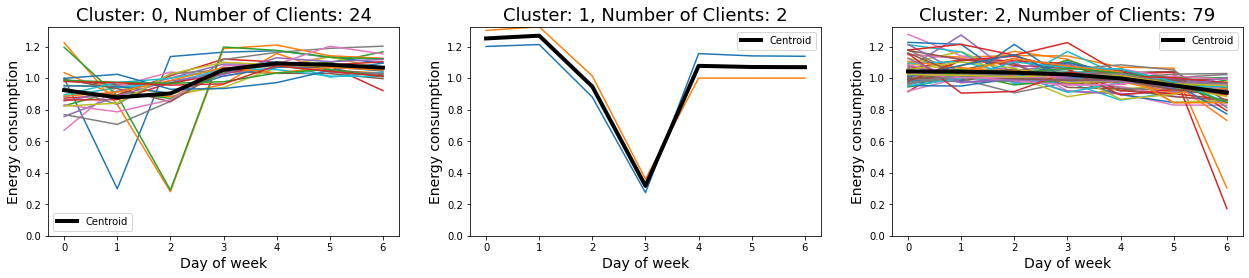

In [188]:
k = 3
nrows = 1
ncols = 3
draw_clusters(X100w, km100wk[k-1].labels_, km100wk[k-1].cluster_centers_, nrows, ncols,'Day of week')

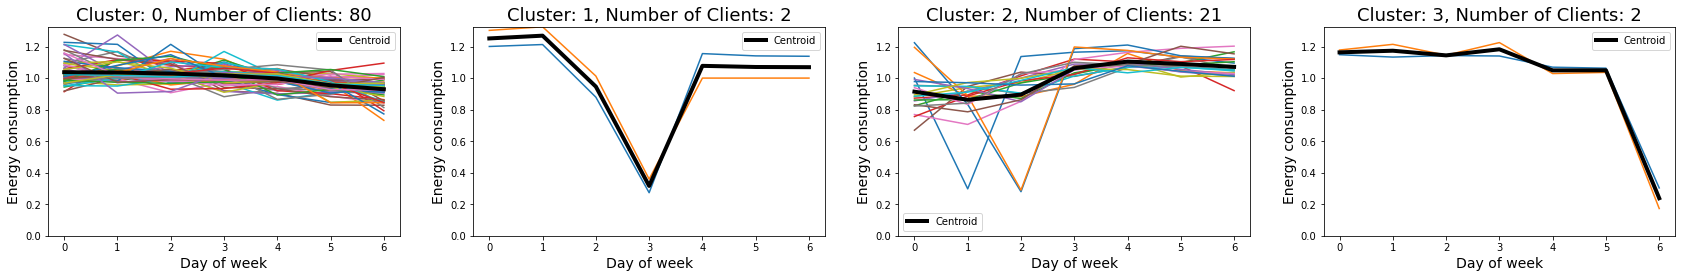

In [189]:
k = 4
nrows = 1
ncols = 4
draw_clusters(X100w, km100wk[k-1].labels_, km100wk[k-1].cluster_centers_, nrows, ncols,'Day of week')

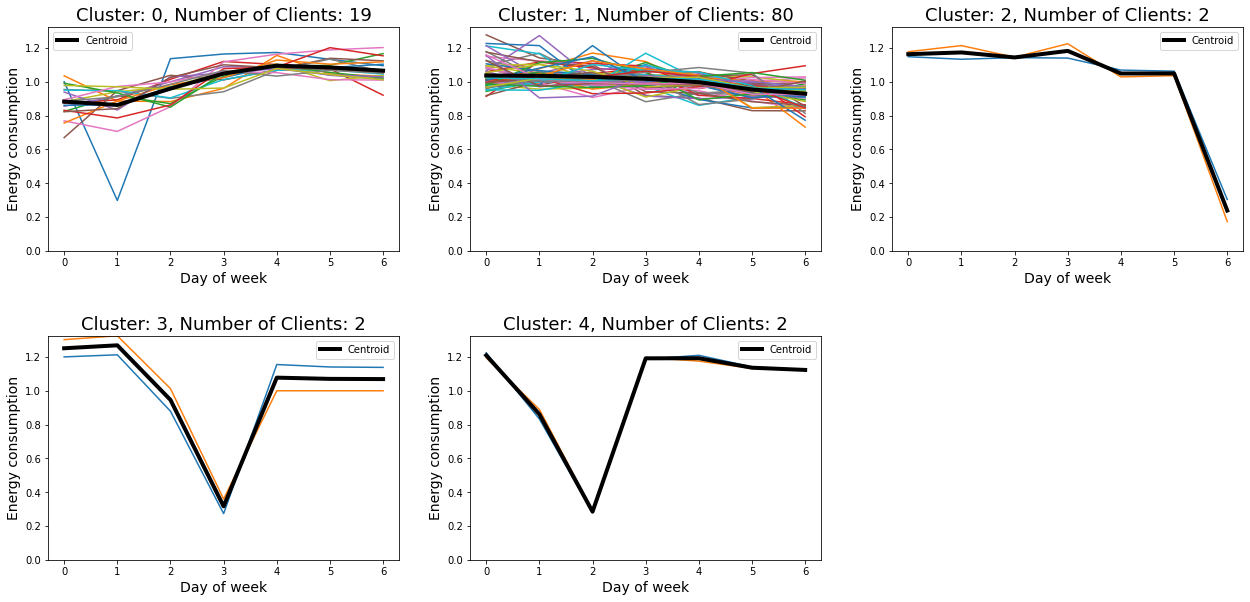

In [190]:
k = 5
nrows = 2
ncols = 3
draw_clusters(X100w, km100wk[k-1].labels_, km100wk[k-1].cluster_centers_, nrows, ncols,'Day of week')

The plots of clusters suggests the when K=4, the algorithm is able to group the weeks into 4 clusters: 1) Weeks with a very minor decline but relative constant throughout the week; 2) Weeks with a sharp decline on Wednesadya nd Thursday; 3) Weeks with realtively low consumption from Monday to Wednesday; 4) Weeks similar to 1) but with very low consumption on Sunday.<br>
When k=5, the algorithm separated an additional cluster for weeks with a sharp drop of energy consumption on Tuesday and Wednesady.

##### ***Draw Silhouette diagram***

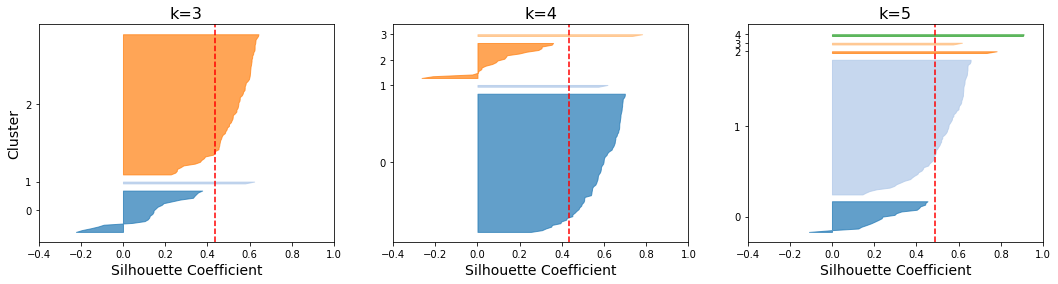

In [194]:
nrows=1
ncols=3
plt.figure(figsize=(6*ncols, 4*nrows))
k1 = km100wk[0].n_clusters # first k value
if k1 == 1:  k1s = 2
else:  k1s = k1
k1p = 3 #first k value for plotting
g=1
for k in range(k1p,6):
    plt.subplot(nrows, ncols, g)
    y_pred = km100wk[k-k1].labels_
    silh_score_k = silcoef100wk[k-k1p]
    plot_silhouette_coeffs(X100w, y_pred, silh_score_k, k, nrows, ncols, k1, k1p)
    g+=1

The cluster plots and silhouette diagrams indicate that performance of KMeans is similar when k=4 and 5. In the clusters at index 2 (k=4) or 0 (k=5) a small number of instances have negative values (suggesting low coherence). These instances are most likely outliers as shown in the cluster plots. <br>
The weekly trend of the energy consumption for client MT_100 demonstrates a similar major pattern to that for all clients, but also has more week-by-week variations and outliers.

#### Single client "MT_100" monthly

In [196]:
mt_100m = dailydata[['MT_100','day','date']].copy()
mt_100m['month'] = pd.to_datetime(dailydata.index).month
# Use all months in 2 years
mt_100m['yearmon'] = [str(dailydata['date'][i].year)+'-'+str(mt_100m['month'][i]) if mt_100m['month'][i]>=10 
                      else str(dailydata['date'][i].year)+'-0'+str(mt_100m['month'][i]) for i in range(mt_100m.shape[0])]
mt_100m = mt_100m.drop('2015-01-01',axis=0)
mt_100m = mt_100m.pivot(index='yearmon',columns='day',values='MT_100')
mt_100m = mt_100m.T.fillna(mt_100m.T.mean()).T
mt_100m.head()

day             1          2          3          4          5          6   \
yearmon                                                                     
2013-01  11.129021  42.471150  43.504494  43.844319  42.339381  40.917665   
2013-02  43.768032  42.006491  41.167332  43.878995  43.490624  43.324179   
2013-03  43.615457  39.849645  39.017421  42.582113  43.823513  43.823513   
2013-04  40.328174  40.792832  42.630659  42.422603  43.684809  39.912062   
2013-05  42.478085  46.230027  55.620284  50.335664  49.697625  49.413282   

day             7          8          9          10  ...         22  \
yearmon                                              ...              
2013-01  44.267366  43.740291  44.461551  44.121727  ...  44.454616   
2013-02  43.365790  42.595983  40.321238  39.371116  ...  43.553040   
2013-03  42.651465  42.776298  40.570905  39.489015  ...  43.025965   
2013-04  38.559698  44.870728  41.888593  42.797104  ...  48.581059   
2013-05  54.982246  52.173491  61.917443  65.322625  ...  62.298879   

day             23         24         25         26         27         28  \
yearmon                                                                     
2013-01  44.648802  43.629328  44.204949  41.805371  40.563970  43.955282   
2013-02  40.099312  40.238016  43.899800  44.253495  43.344984  44.260431   
2013-03  40.279627  39.301764  42.318575  41.756824  42.117455  42.013427   
2013-04  50.793387  54.448236  48.705892  44.468486  46.528240  45.307645   
2013-05  68.790224  67.673657  66.092432  56.521860  61.487461  56.584277   

day             29         30         31  
yearmon                                   
2013-01  44.267366  44.579450  43.129993  
2013-02  42.413934  42.413934  42.413934  
2013-03  39.398857  39.163060  11.186474  
2013-04  49.801653  42.616789  44.886679  
2013-05  51.632545  55.377552  58.068409  

[5 rows x 31 columns]

In [198]:
X100m = np.array(mt_100m)
X100m = np.array([X100m[i]/np.nanmean(X100m[i]) for i in range(len(X100m))])
X100m.shape

(24, 31)

***There are more features than the instances. Can we still find patterns and separate them?***

First guess is that there might be 4 clusters, one for each season.<br>
But let's first plot the elbow graph and silhouette coefficients.

In [265]:
km100m = KMeans(2, random_state=42).fit(X100m)
km100m.labels_

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0], dtype=int32)

In [201]:
k_range = range(1,15)
km100m = [KMeans(k, random_state=42).fit(X100m) for k in k_range]
sse100m = [model.inertia_ for model in km100m]
silcoef100m = [silhouette_score(X100m,model.labels_) for model in km100m if model.n_clusters!=1]

print(len(sse100m), len(silcoef100m))

14 13


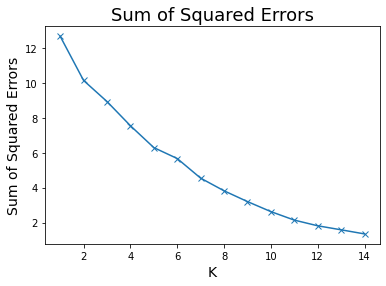

In [202]:
plot_optimal_k(k_range,sse100m)

The intertia elbow graph does not show an obvious kink bend and the inertia reduces gradually with increasing k value.

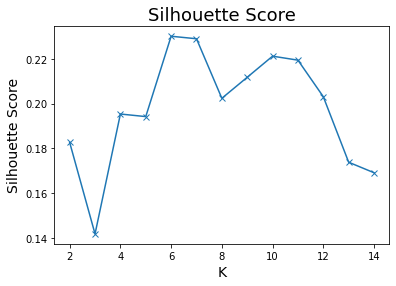

In [203]:
plot_optimal_k(k_range[1:],silcoef100m,'Silhouette Score')

The Silhouette Coefficient graph suggests that k=6 or 7 may be a good number of clusters.

##### ***Plot clusters***

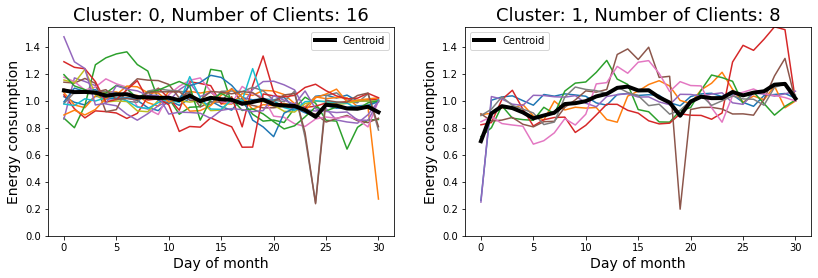

In [204]:
k = 2
nrows = 1
ncols = 2
draw_clusters(X100m, km100m[k-1].labels_, km100m[k-1].cluster_centers_, nrows, ncols,'Day of month')

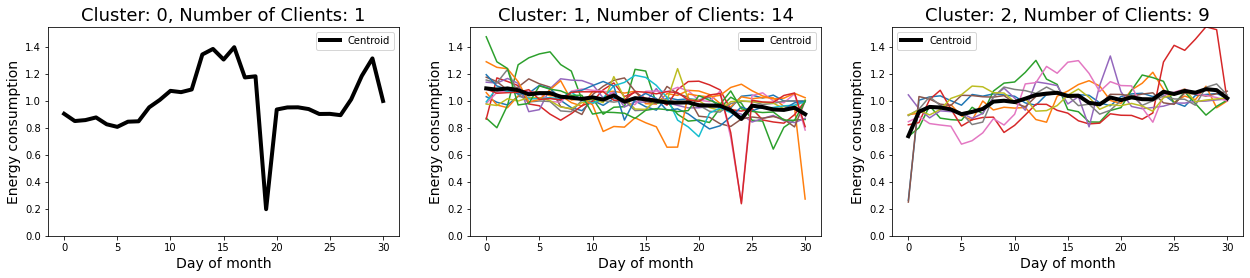

In [205]:
k = 3
nrows = 1
ncols = 3
draw_clusters(X100m, km100m[k-1].labels_, km100m[k-1].cluster_centers_, nrows, ncols,'Day of month')

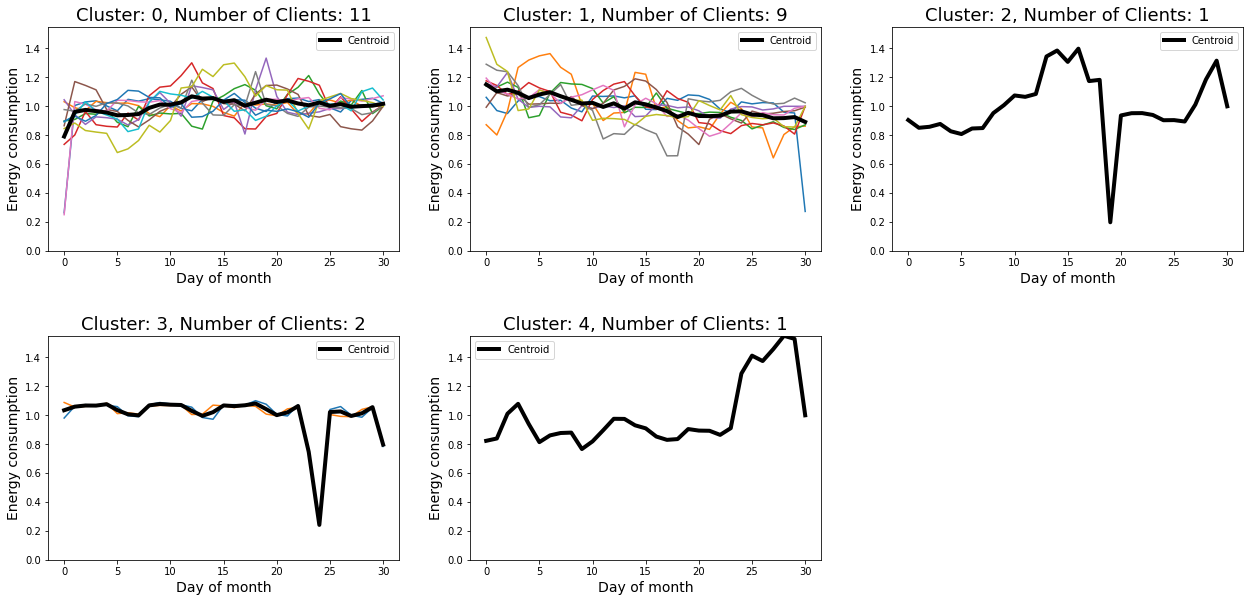

In [206]:
k = 5
nrows = 2
ncols = 3
draw_clusters(X100m, km100m[k-1].labels_, km100m[k-1].cluster_centers_, nrows, ncols,'Day of month')

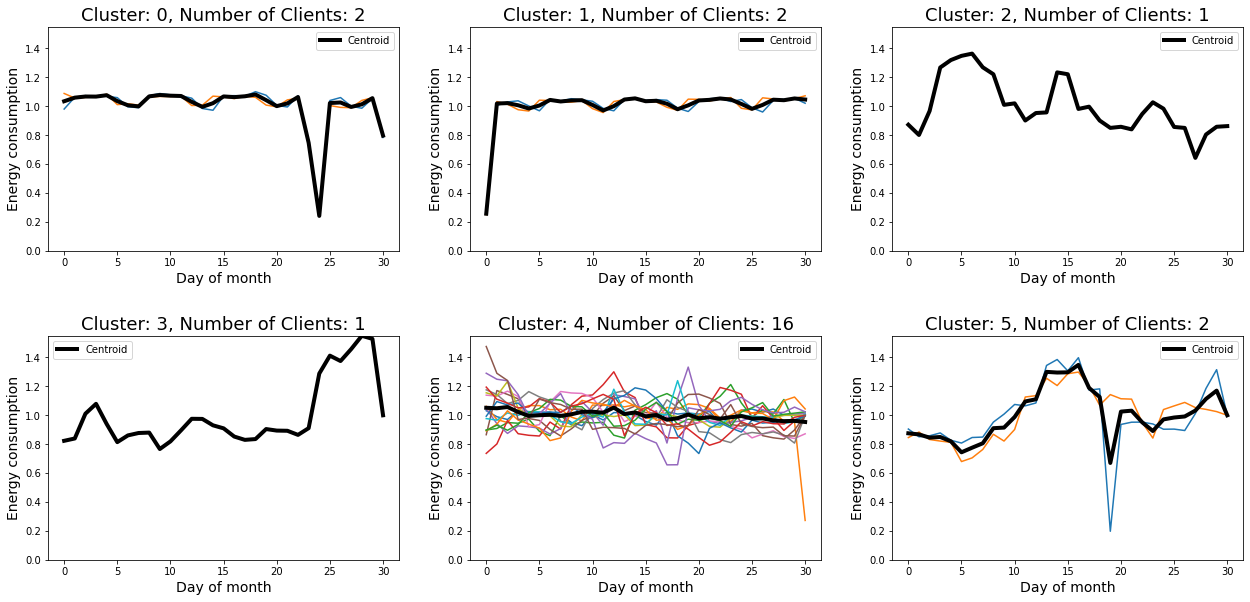

In [207]:
k = 6
nrows = 2
ncols = 3
draw_clusters(X100m, km100m[k-1].labels_, km100m[k-1].cluster_centers_, nrows, ncols,'Day of month')

The plots of clusters suggests the when K=2, the algorithm separates the months into 2 clusters: 1) months with a slightly increasing consumptions; 2) months with a slightly deccreasing consumptions, while there are considerable variations within each cluster.The pattern of monthly energy consumptions is not visibly obvious. <br>
Further increasing the k value separates single outlier curves into separate clusters. For example, when k=6, the algorithm separate most of distinct curves into separate clusters, with all other months grouped into one large cluster having 16 out of 24 months (instances).

##### ***Draw Silhouette diagram***

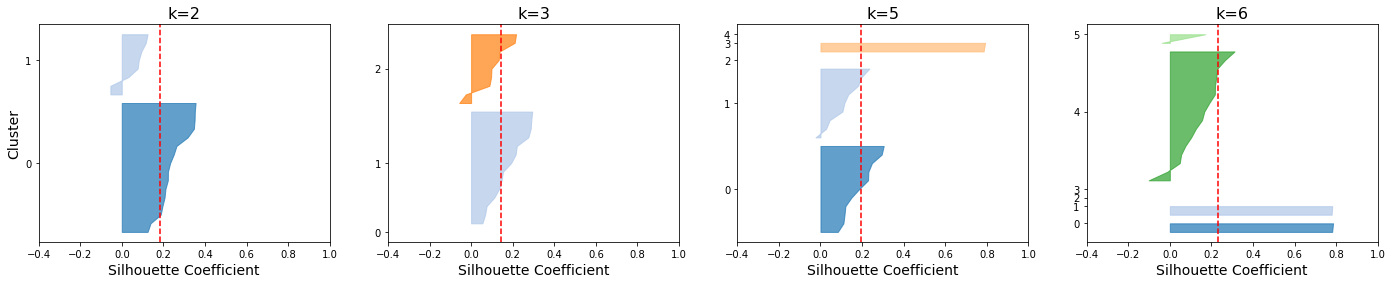

In [220]:
# plot silhouette coeffs
nrows=1
ncols=4
plt.figure(figsize=(6*ncols, 4*nrows))
k1 = km100m[0].n_clusters # first k value in the kmeans model
if k1 == 1:  k1s = 2
else:  k1s = k1
k1p = 2 #first k value for plotting
g=1
for k in (2,3,5,6):
  plt.subplot(nrows, ncols, g)
  y_pred = km100m[k-k1].labels_
  silh_score_k = silcoef100m[k-k1s]
  plot_silhouette_coeffs(X100m, y_pred, silh_score_k, k, nrows, ncols, k1, k1p)
  g=g+1

The silhouette diagrams indicates a poor performance when k=2. The diagrams are not too bad for k=3,5,6, except that for clusters with only one instance, the silhouette scores become zero.

### **Summary**
-- ***The energy clients can be grouped into 5 clusters that showed distinct patterns of energy consumptions***.<br>
-- ***Different clients have different consumption behaviours. Analyses can be performed on the clients of interests to study their patterns***.<br>

Whether for all clients or for individual clients, there exist some patterns of weekly engery consumptions for days in a week, but no significant monthly patterns for days in a month among clients. For individual clients, such as MT_100, k=6 may separate most outliers from single normal monthly consumption pattern into separate clusters.<br>
In terms of weekly behavior, ***Clients*** can be grouped into ***3 clusters*** whose weekly consumption patterns are ***constant consumption each day*** in a week, higher weekday consumption and ***low weekend consumptions***, and lower weekday consumptions and ***high weekend consumption***, respectively. <br>
***Client MT_100*** has a ***similar weekly patterns to all clients***. However, a single client has ***more week-to-week variations*** than that of all clients. For client MT_100, k=4 seems a good number of clusters to group weekly consumption patterns into clusters. 

-- ***Different clustering performance evaluation methods do not always agree with each other***, but from the two clients that we analyzed, the elbow graph and overall silhoutte coeffient genrally gave consistent suggestions of good k values. If possible, ***visualizing the clusters may help assess the performance of the clustering method***. <br>
-- Silhouette analysis gives more informative visualization by plotting sorted silhouette scores for each instance in each cluster using **silhouette diagram**. This diagram can greatly help ***evaluate the performance of clustering algorithm and parameters*** which sometimes may mislead by using inertia elbow graph or overall silhoutte coefficient alone.

**--- END ---**